## Freedmen's Bureau Documents Analysis

In [34]:
import os
from openai import OpenAI
import ollama
import pandas as pd
from langchain.schema import HumanMessage, SystemMessage, AIMessage
from langchain_ollama import ChatOllama

In [3]:
df_contracts = pd.read_csv('archive/contract-records.csv')
df_contracts.head()

,project_id,category,sub_category,transcription_text,document_url
0,11406,Contracts,Apprenticeship Agreement,Copy_x000D_\n_x000D_\nAgreement of Apprentices...,https://transcription.si.edu/transcribe/11406/...
1,11406,Contracts,Apprenticeship Agreement,[H 132 ENCL] _x000D_\n_x000D_\nCopy_x000D_\n_x...,https://transcription.si.edu/transcribe/11406/...
2,11406,Contracts,Apprenticeship Agreement,is agreed on the part of the party of the firs...,https://transcription.si.edu/transcribe/11406/...
3,11406,Contracts,Apprenticeship Agreement,continuance of this agreement & finally that t...,https://transcription.si.edu/transcribe/11406/...
4,15369,Contracts,Apprenticeship Agreement,"[[preprinted]]_x000D_\nBureau of Refugees, Fre...",https://transcription.si.edu/transcribe/15369/...


### LLM configuration for python (OpenAI API, Ollama)

- OpenAI

In [5]:
client = OpenAI(
    api_key = os.environ["OPENAI_API_KEY"],
    )
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Why is the sky blue?",
        }
    ],
    model="gpt-3.5-turbo",
)

- Ollama

In [3]:
response = ollama.chat(model='llama3.1', messages=[
  {
    'role': 'user',
    'content': 'Why is the sky blue?',
  },
])
print(response['message']['content'])

The sky appears blue to us because of a phenomenon called scattering, which involves the interaction between sunlight and the tiny molecules of gases in the atmosphere.

Here's what happens:

1. **Sunlight enters Earth's atmosphere**: When the sun shines, it sends out a wide range of electromagnetic radiation, including visible light, ultraviolet (UV) rays, and infrared (IR) radiation.
2. **Scattering occurs**: As sunlight travels through the atmosphere, it encounters tiny molecules of gases like nitrogen (N2) and oxygen (O2). These molecules are much smaller than the wavelength of light.
3. **Short wavelengths scattered more**: When light hits these gas molecules, some of it scatters in all directions. This scattering effect is more pronounced for shorter (blue) wavelengths than longer (red) wavelengths.
4. **Blue light reaches our eyes**: As a result of this scattering, the blue light from the sun becomes dispersed and reaches our eyes from all parts of the sky. The blue color domina

### Parsing sentences

In [19]:
inputs = [
    "John James agrees to pay $50/month to RJ Hampshire for work on the Farm",
    "Elizabeth James will pay $30 per month to Levi Rodgers for Gardening",
    "Johnson Ollaman will pay $1.25 per day to both John Smith and Jane Smith for teaching the children of the community",
    "Claire Daniels charges $50 weekly to local community members for cooking classes, emphasizing the joy of healthy eating.",
    "Marcus Wellby commits to donating $500 annually to the Green Earth Foundation for environmental conservation efforts.",
    "Dr. Helena Russell charges $100 per hour for providing guidance and support to medical students, aiming to enhance their clinical skills and knowledge.",
    "The local sports club agrees to pay $75 each to coaches Sarah Miller, Danny Glover, Alex Reed, and Jamie Fox for conducting a weekend sports clinic.",
    """This Agreement made this 14th day of August A.D. 1865, by and between F.R.J. Terry of the county of Copiah and State of Mississippi of the first part, and the person hereinafter named and undersigned,
    Freedmen of the second part [[?]] That for the purpose of working in the [[?]] known as Beagley's [[?]] Yard in the county aforesaid for two months commencing on the 14th day of August 1865 and terminating
    on the 14th day of October 1865. The said F.R.J. Terry party of the first part, in consideration of the [[?]] and conditions hereinafter mentioned on the part of the party of the second part agrees to pay said
    laborer "10" ten dollars per month and furnish free of charge clothing and good of good quality and sufficient quantity, good and sufficient quarters, and kind and humane treatment. And it is further agreed
    that in case the said F.R.J. Terry shall fail, neglect, or refuse to fulfill any of the obligations assumed by him, he shall besides the legal recourse left to the party aggrieved render this contract liable
    to amendment by the Provost Marshal of Freedmen. And it is agreed on the part of the party of second part that he will well and faithfully perform such labor as the said F.R.J. Terry may require of him for the
    time aforesaid, nor exceeding ten hours per day in summer and nine hours in winter. And in case the said laborer shall absent himself from or refuse to perform the labor herein promised, he shall loose the time
    and be punished as such manner as the Provost Marshal shall deem propper.""",
]

outputs = [
    [{"payer": "John James", "recipient": "RJ Hampshire", "amount": 50, "pay frequency": "monthly", "description": "farming"}],
    [{"payer": "Elizabeth James", "recipient": "Levi Rodgers", "amount": 30, "pay frequency": "monthly", "description": "gardening"}],
    [{"payer": "Johnson Ollaman", "recipient": "John Smith", "amount": 1.25, "pay frequency": "daily", "description": "teaching the children of the community"}, {"payer": "Johnson Ollaman", "recipient": "Jane Smith", "amount": 1.25, "pay frequency": "daily", "description": "teaching the children of the community"}],
    [{"payer": "Claire Daniels", "recipient": "Local community members", "amount": 50, "pay frequency": "weekly", "description": "cooking classes"}],
    [{"payer": "Marcus Wellby", "recipient": "Green Earth Foundation", "amount": 500, "pay frequency": "yearly", "description": "donation for environmental conservation"}],
    [{"payer": "Dr. Helena Russell", "recipient": "Medical students", "amount": 100, "pay frequency": "hourly", "description": "mentorship and clinical skill enhancement"}],
    [{"payer": "The local sports club", "recipient": "Sarah Miller", "amount": 75, "pay frequency": "one-time", "description": "weekend sports clinic"},
     {"payer": "The local sports club", "recipient": "Danny Glover", "amount": 75, "pay frequency": "one-time", "description": "weekend sports clinic"},
     {"payer": "The local sports club", "recipient": "Alex Reed", "amount": 75, "pay frequency": "one-time", "description": "weekend sports clinic"},
     {"payer": "The local sports club", "recipient": "Jamie Fox", "amount": 75, "pay frequency": "one-time", "description": "weekend sports clinic"}],
    [{"payer": "F.R.J. Terry", "payee": "Freedmen", "amount":10, "pay frequency": "monthly", "description": "working in the yard"}],
]

In [29]:
system_message = """From any given sentcence, grab a payer, recipient, amout, pay frequuency and description. Output shoud be as JSON format. 
Note that there may be a few recipients (if they are being paid, each should have a full sepearate entry). Do not write anything around, I just need plain information"""

response = ollama.chat(model='llama3.1', messages=[
  {
    'role': 'system',
    'content': system_message
  },
  {
    'role': 'user',
    'content': inputs[0]
  },
  {
    'role': 'assistant',
    'content': str(outputs[0])
  },
  {
    'role': 'user',
    'content': "The local sports club agrees to pay $75 each to coaches Sarah Miller, Danny Glover, Alex Reed, and Jamie Fox for conducting a weekend sports clinic."
  }
])
print(response['message']['content'])

[{'payer': 'local sports club', 'recipient': 'Sarah Miller', 'amount': 75, 'pay frequency': 'one-time', 'description': 'sports clinic'}, 
 {'payer': 'local sports club', 'recipient': 'Danny Glover', 'amount': 75, 'pay frequency': 'one-time', 'description': 'sports clinic'}, 
 {'payer': 'local sports club', 'recipient': 'Alex Reed', 'amount': 75, 'pay frequency': 'one-time', 'description': 'sports clinic'}, 
 {'payer': 'local sports club', 'recipient': 'Jamie Fox', 'amount': 75, 'pay frequency': 'one-time', 'description': 'sports clinic'}]


#### Selecting Apprenticeship Agreement 

In [4]:
df_contracts.sub_category.unique()

array(['Apprenticeship Agreement', 'Apprenticeship Agreements',
       'Character Reference', 'Cover Page', 'Labor Contracts',
       'labor Contracts', 'Oath', 'Reports - Contracts'], dtype=object)

In [5]:
df_contracts.sub_category.value_counts()

sub_category
Labor Contracts              12233
Cover Page                    8101
Apprenticeship Agreement      2405
Reports - Contracts             85
Oath                            14
Character Reference             10
Apprenticeship Agreements        1
labor Contracts                  1
Name: count, dtype: int64

In [8]:
df_contracts_Agreements = df_contracts[df_contracts["sub_category"].isin(['Apprenticeship Agreement', 'Apprenticeship Agreements'])]
len(df_contracts_Agreements)

2406

In [12]:
pd.set_option('display.max_colwidth', None)
df_contracts_Agreements.loc[:, 'transcription_text'] = df_contracts_Agreements['transcription_text'].str.replace("_x000D_", " ")
df_contracts_Agreements.head(3)

,project_id,category,sub_category,transcription_text,document_url
0,11406,Contracts,Apprenticeship Agreement,Copy \n \nAgreement of Apprenticeship \nBu \nMrs. Kate V.Chamblin \nof the first part and \n \n1st Lt. Geo. W. Rollins \nV.R.C. U.S. Army Agt \nfor Carroll Parish La. of \nthe second part \n \nMinor Orphans Freed \nJames Samenett \nBetty Taylor \nMary Taylor \n \nLake Providence \nCarroll Parish La \nDated Oct. 1 1866 \nExec'd Nov. 3 1866 \n,https://transcription.si.edu/transcribe/11406/NMAAHC-004567395_00439
1,11406,Contracts,Apprenticeship Agreement,"[H 132 ENCL] \n \nCopy \n \nAgreement of Apprenticeship. \n \nThis agreement in two parts made & entered into this 1"" day of October A. D. 1866 by & between Mrs Kate V. Chambliss of the first part and 1st Lieut Geo. W. Rollins Vet Res. Corps U.S.A. Agent for Carroll Parish La. Bur of Ref. Freedn & Aband Lands La and by virtue of authority contained in Circular No 25 dated Hd. Qrs. Bur Ref Freedn & Abd Lands New Orleans Louisiana Octr 31"" 1865 Guardian for Minors & orphans of Freedmen for Carroll Parish La party hereto of the second part. Witnesseth That James Samenett, Betty Taylor and Mary Taylor minor orphans of African decent are hereby bound & apprenticed to service to the said Mrs Kate V. Chambliss party of the first part & undersigned during their years of minority commencing & ending as follows: James Samenett aged 14 years, commencing on the 1"" day of Oct. A. D. 1866 & terminating on the 1"" day of October 1870. Betty Taylor aged 9 years commencing on the 1"" day of Oct. A. D. 1866 & ending on the 1"" day of Oct. A. D. 1872. Mary Taylor aged 7 years commencing on the 1"" day of October A. D. 1866 & terminating on the 1"" day of October A. D. 1874. And it",https://transcription.si.edu/transcribe/11406/NMAAHC-004567395_00440
2,11406,Contracts,Apprenticeship Agreement,"is agreed on the part of the party of the first part & undersigned Mrs Kate V. Chambliss that for the consideration of the faithfull services to be rendered by the within named & said minor orphans the said minor orphans shall receive comfortable clothing, board medical treatment when sick, a reasonable amount of schooling and permission to attend church each Sabbath and at the end or termination of their term of apprenticeship the said minor orphans shall be allowed to retain all articles of their personal apparel. \n \nThe said parties do hereby mutually agree that all laws or parts of laws enacted or that may be enacted by the United States or the State of Louisiana establishing laws for the welfare or government of Freedmens minors or orphans or for the government of the same under laws establishing the Bur of Ref Freed & Ab^d Lands or in any way affecting the provisions of this agreement is & shall be made a part of this agreement and that all laws applying to white minors or orphans shall be extended to the said & within named minor orphans during the conti-",https://transcription.si.edu/transcribe/11406/NMAAHC-004567395_00441


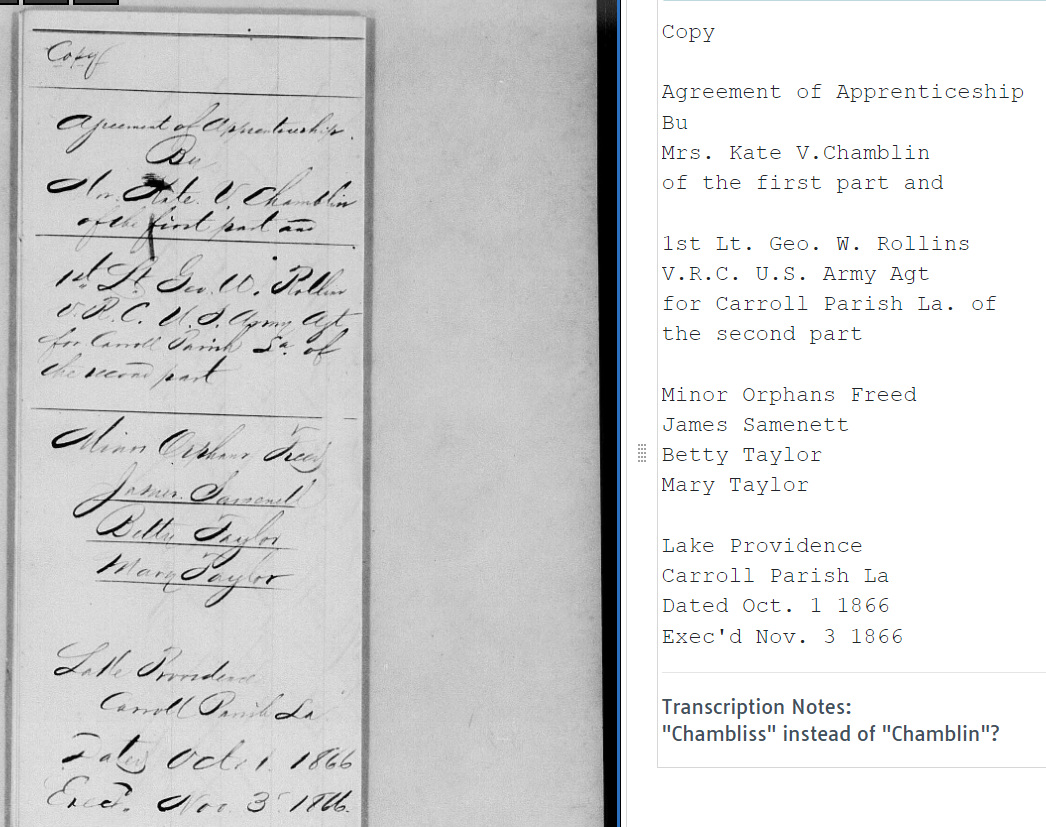

### Connect pages from the same documents

In [13]:
aa_contracts = df_contracts_Agreements.head(50)
len(aa_contracts)

50

In [41]:
system_message = """Your task is to determine if two pages (given records) are from the same document. 
You should check for the same names, places, dates etc. appear in both documents.
If they do, return True, else False. Important: Return ONLY the boolean value."""

In [32]:
# ollama run llama3.1

In [42]:
### TEST ###
model = ChatOllama(model="llama3.1")

doc1 = "John James agrees to pay $50/month to RJ Hampshire for  work on the Farm."
doc2 = "Johnson Ollaman will pay $1.25 per day to both John Smith and Jane Smith for teaching the children of the community."

doc3 = "Claire Daniels charges $50 weekly to local community members for cooking classes, emphasizing the joy of healthy eating."
doc4 = "Claire Daniels charges in addition $75 weekly for teaching the children."

messages = [
            SystemMessage(
                content=system_message
            ),
            HumanMessage(
                content=f"document 1: {doc1} \n\n document 2: {doc2}"
            ),
        ]

chat_model_response = model.invoke(messages, timeout=20)
print(chat_model_response.content)

messages2 = [
            SystemMessage(
                content=system_message
            ),
            HumanMessage(
                content=f"document 3: {doc3} \n\n document 4: {doc4}"
            ),
        ]

chat_model_response = model.invoke(messages2, timeout=20)
print(chat_model_response.content)

False
True


In [ ]:
def is_from_same_doc(input_text):
    try:
        model = ChatOllama(model="llama3.1")
        system_message = """Your task is to determine if two pages (given records) are from the same document. 
                            You should check for the same names, places, dates etc. appear in both documents.
                            If they do, return True, else False. Important: Return ONLY the boolean value."""

        messages = [
            SystemMessage(
                content=system_message
            ),
            HumanMessage(
                content=input_text
            ),
        ]

        chat_model_response = model.invoke(messages, timeout=20)
        return chat_model_response.content
    except Exception as e:
        return None